# TP BE Météo

## Chargement des librairies

cf readme

In [2]:
library(sf)
library(ggplot2)
library("rnaturalearth")
library("rnaturalearthdata")
library(dplyr)
library(glue)

pcolors = c("#FFBE0B", "#FF006E", "#8338EC", "#5A96FF", "#880D1E", "#4CC9F0")

Linking to GEOS 3.12.1, GDAL 3.8.4, PROJ 9.4.0; sf_use_s2() is TRUE


Attaching package: ‘rnaturalearthdata’


The following object is masked from ‘package:rnaturalearth’:

    countries110



Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




## Chargement des données

In [ ]:
# 31s à s'exécuter sur Stuart
data_full_dir = "../data/donnees-synop-essentielles-omm.csv"
# 9s à s'exécuter sur stuart
data_ext10_dir = "../data/donnees_extracted_10.csv"
data_ext10M_dir = "../data/donnees_extracted_metro_10.csv"

full_data <- read.csv(data_ext10_dir, 
            sep=",", # à toggle en fonction du fichier (',' pour les extracts, ';' pour l'originel)
            na.string=c("","null","NaN"),
            header=TRUE, 
            stringsAsFactors=TRUE)

## Fonction de dendogrammerie

In [18]:

auto_dendogram <- function(crit_data, nk){

    # distances
    distances <- dist(crit_data)
    # la distance par défaut est 'complete', ie maximale.
    # plot dendrogramme et sépare l'arbre
    cah_tree <- hclust(distances, method="ward.D")
    clusters <- cutree(cah_tree, k = nk, h = NULL)
    options(repr.plot.width=10, repr.plot.height=8)
    par(bg = 'white')
    plot(cah_tree, main = glue("Dendrogram with {nk} clusters"))
    rectlist = rect.hclust(cah_tree, k = nk, border = 2:(nk+1))

    # plot la hauteur en fonction du nombre de groupe
    # print(cah_tree$height)
    options(repr.plot.width=10, repr.plot.height=8)
    par(bg = 'white')
    plot(cah_tree$height, col='red', type='l')
    grid(col="gray")

    # plot les groupes en couleur sur une carte du monde
    options(repr.plot.width=18, repr.plot.height=12)
    worldmap <- ne_countries(scale = 'medium', type = 'map_units', returnclass = 'sf')

    i <- 1
    p <- ggplot()
    p <- p + geom_sf(data = worldmap, color = "black", fill = "#CAFFDA")
    for(v in rectlist){
        p <- p + geom_point(data = crit_data[rownames(crit_data) %in% names(v), ], 
                aes(x = Longitude, y = Latitude), color = pcolors[[i]], size = 3)
    i <- (i+1)%%length(pcolors)
    }
    p <- p + coord_sf() + theme_minimal()
    print(p)
}

## Critère : latitude et longitude

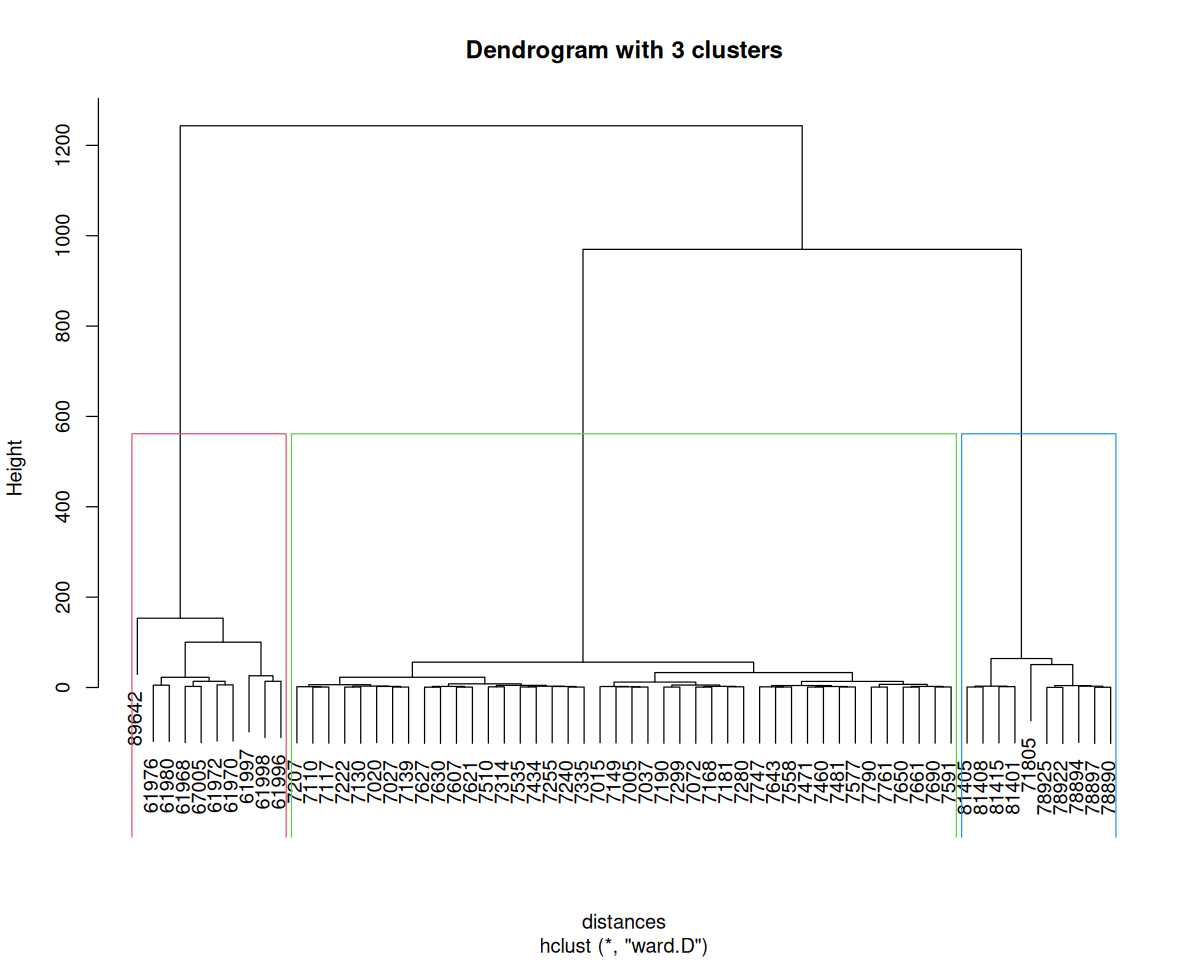

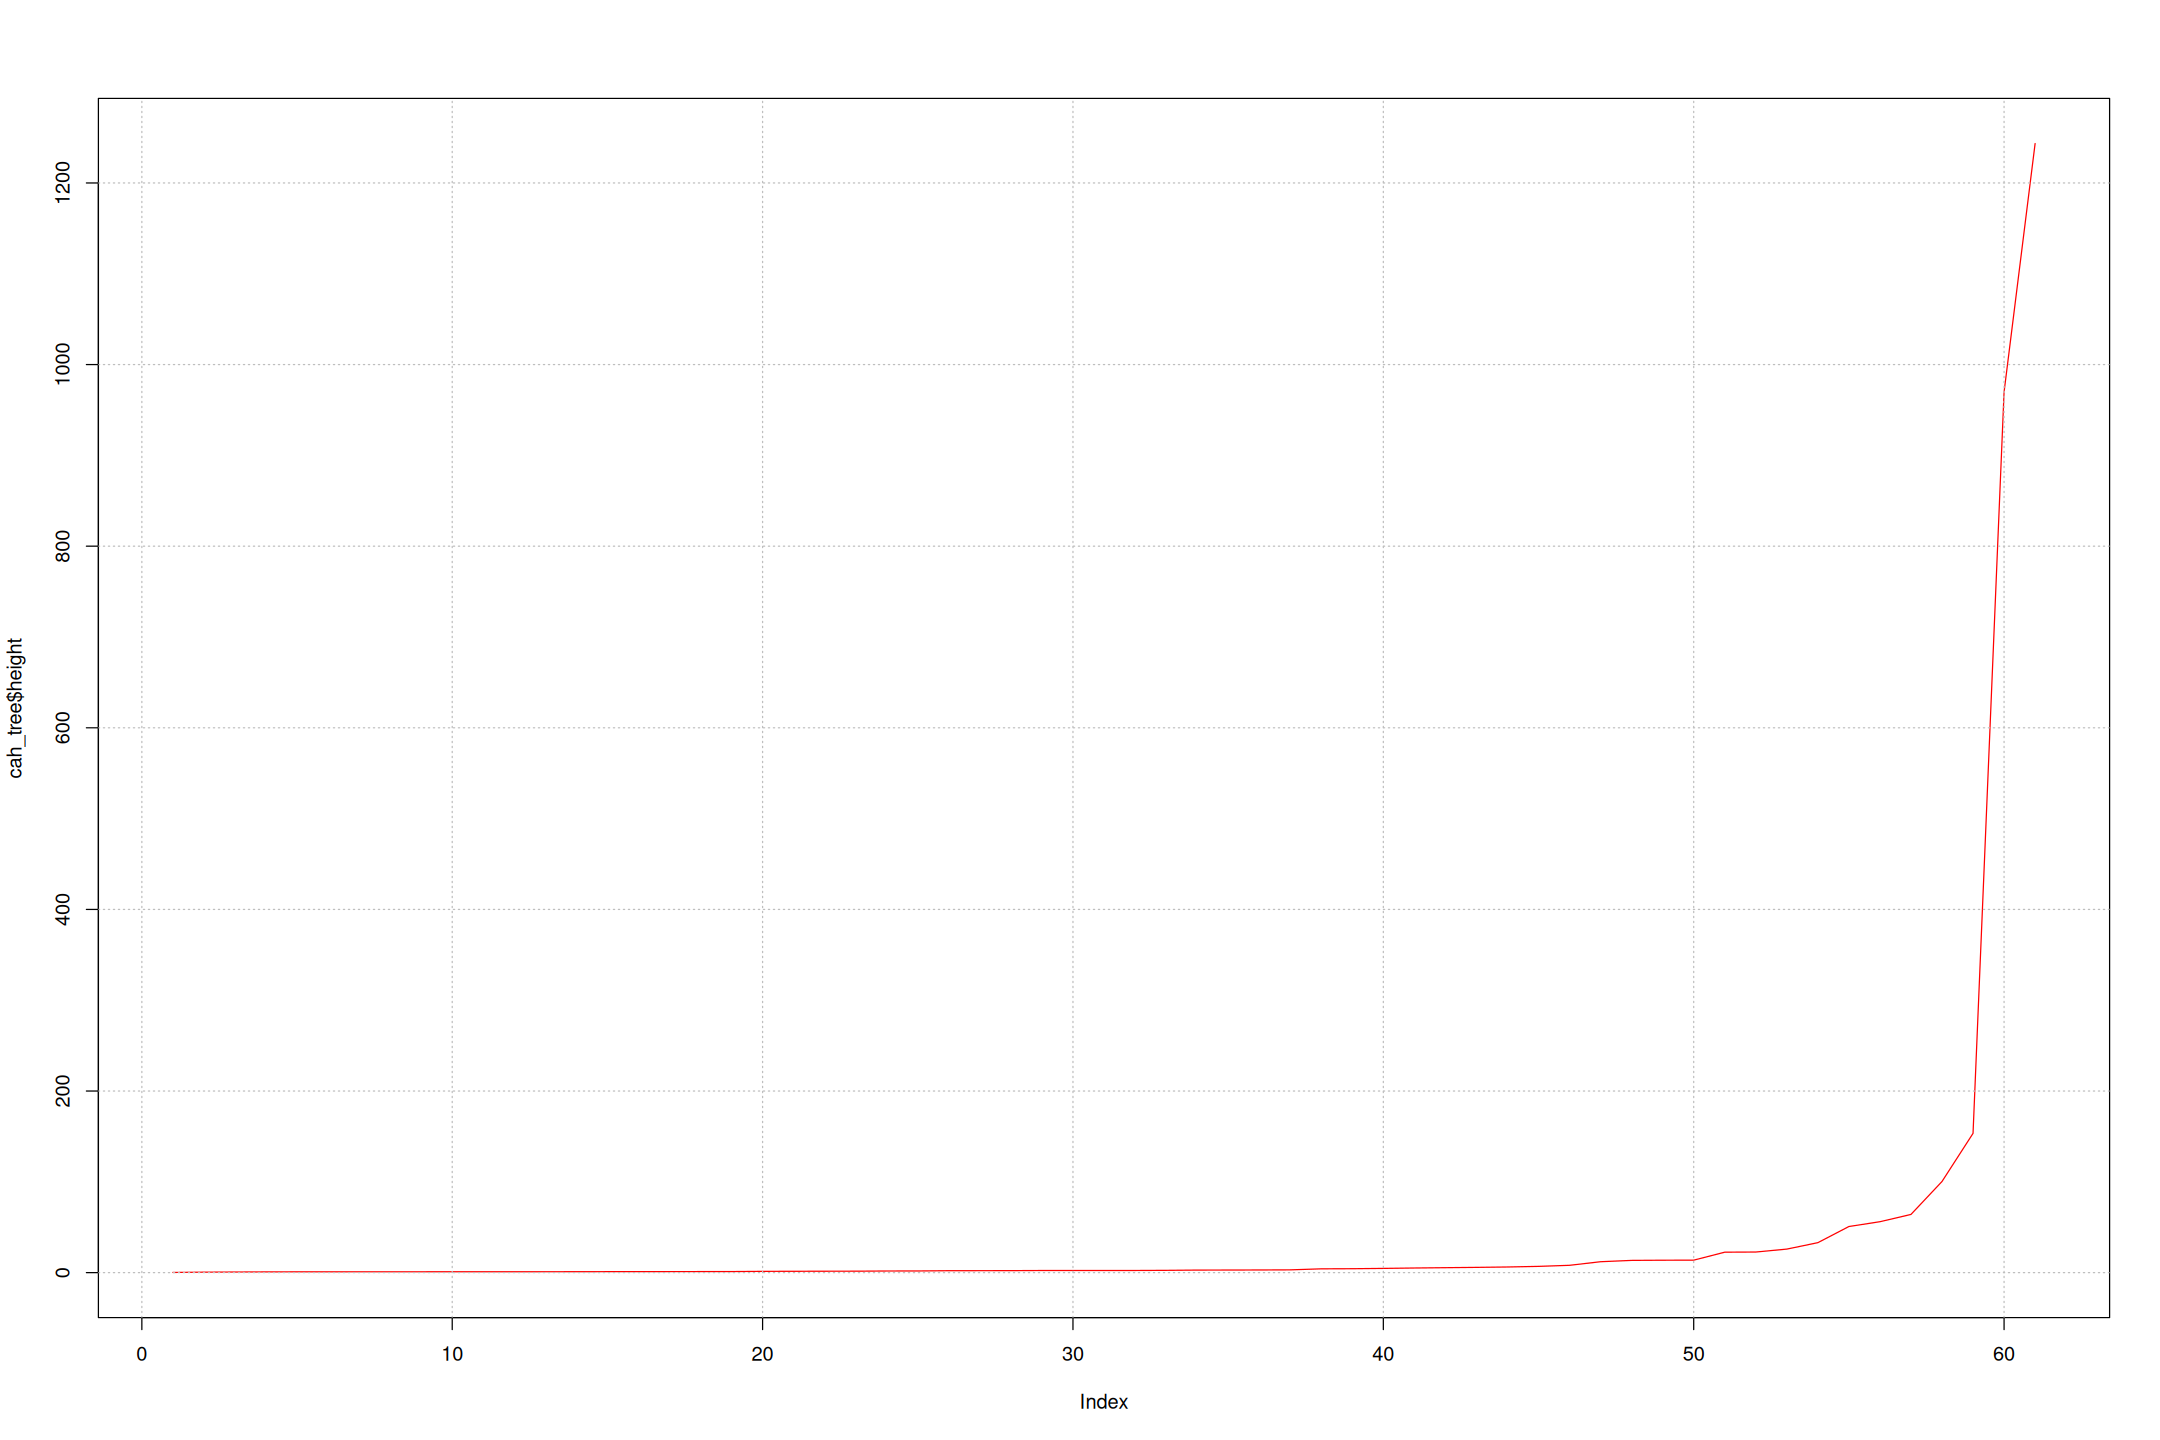

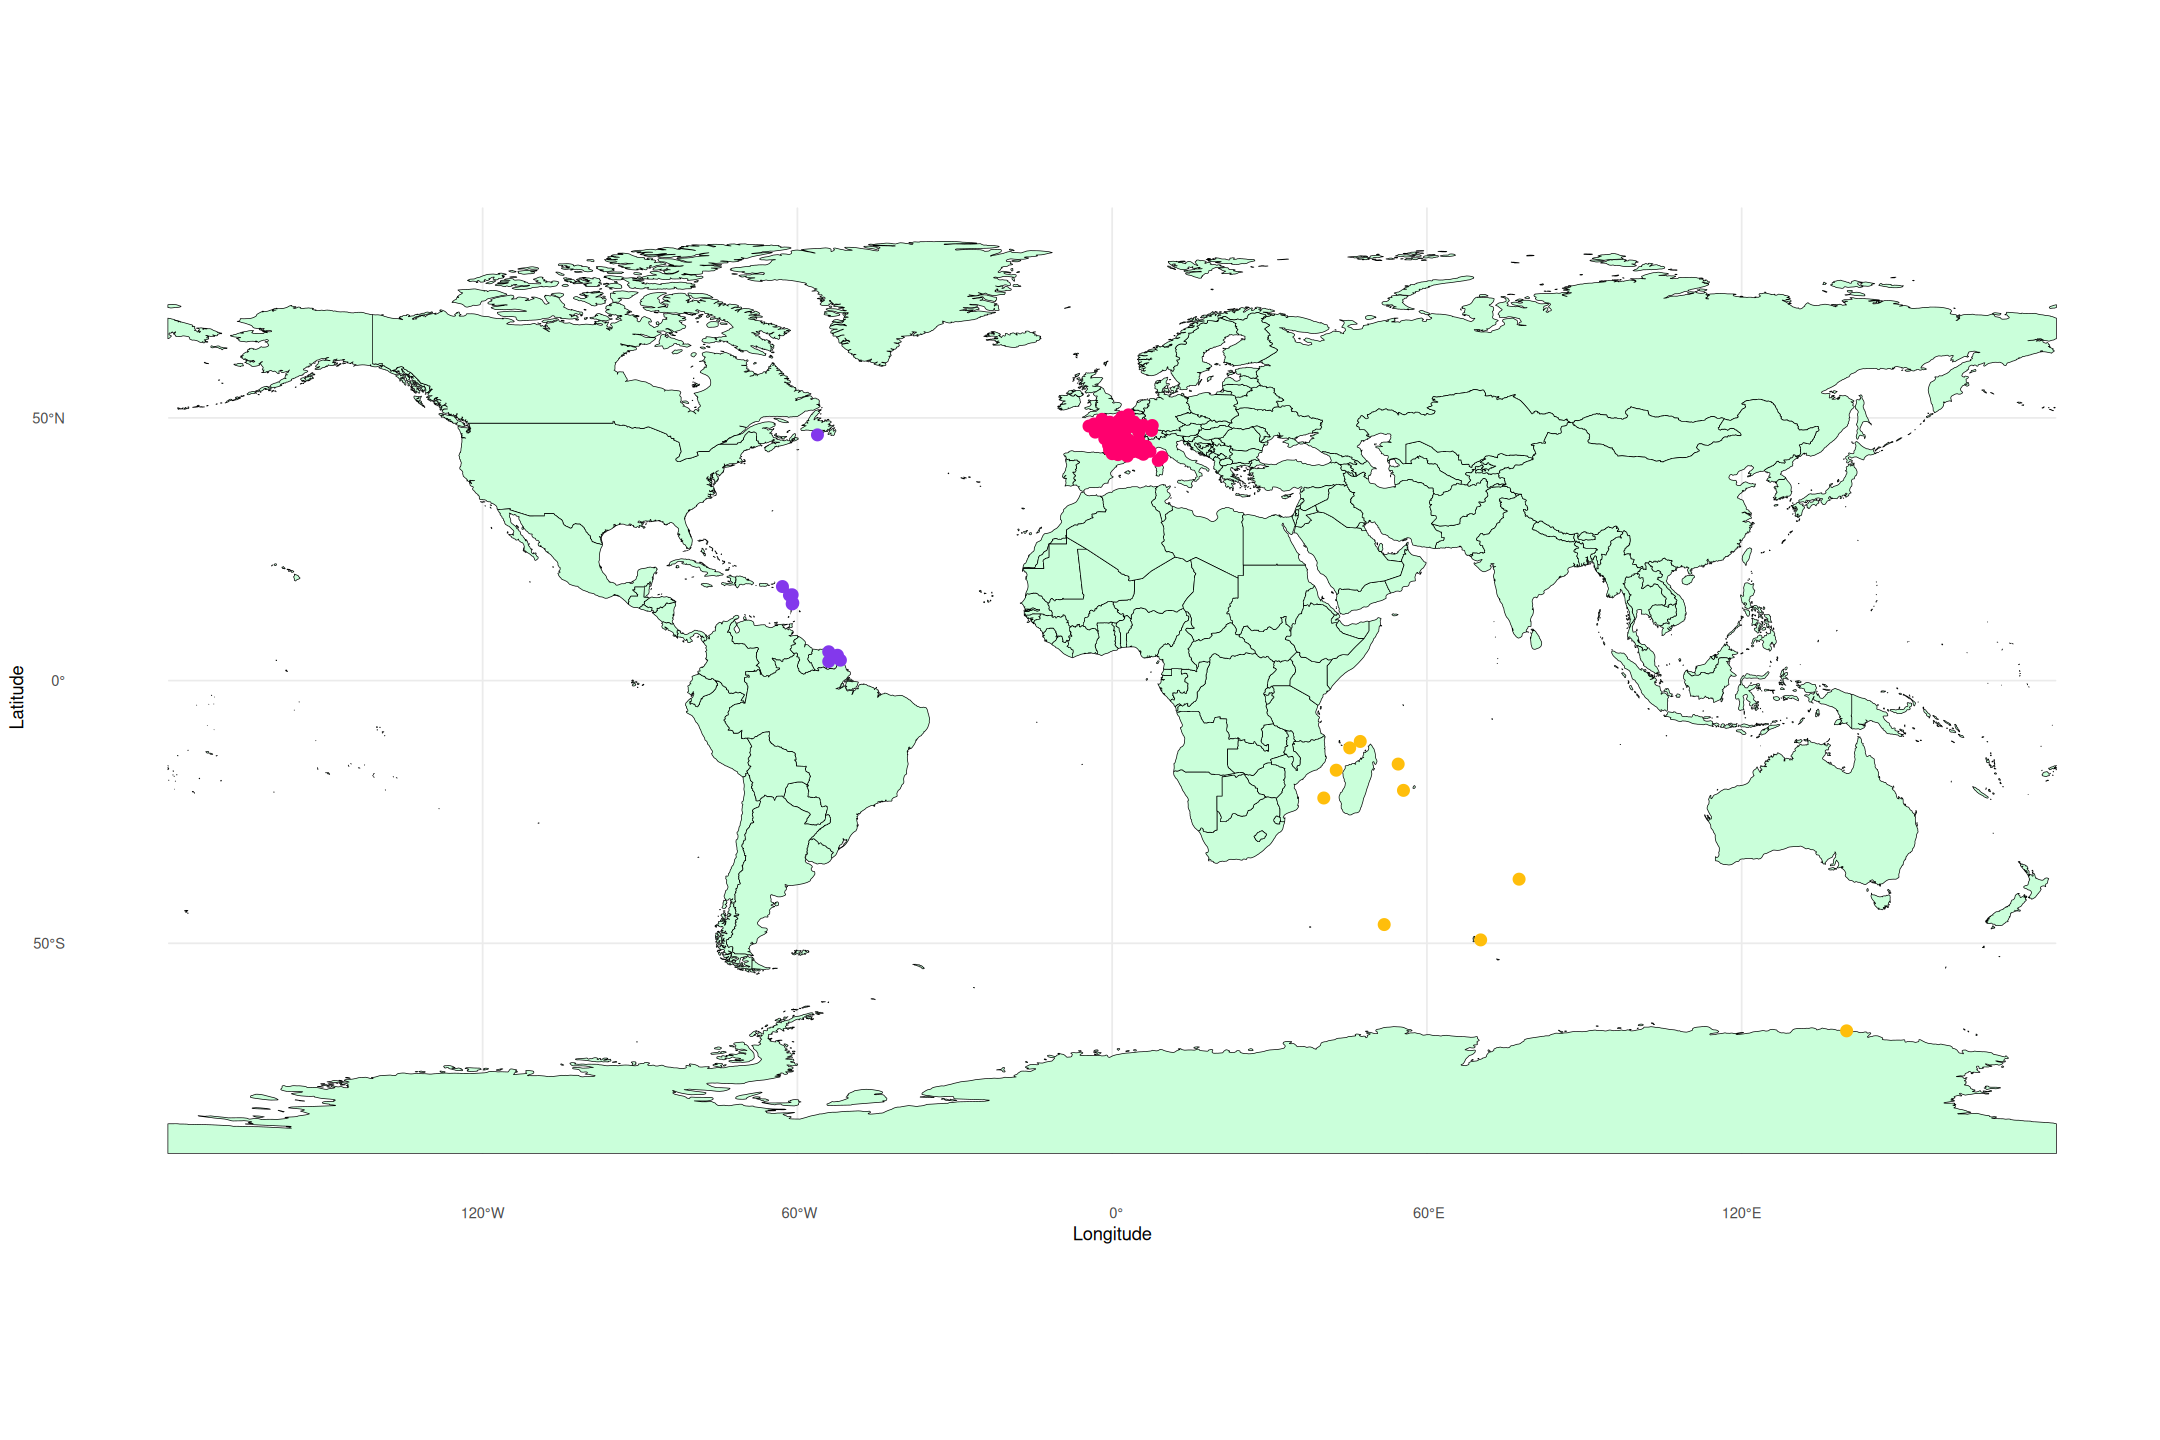

In [19]:
# extract latitudes and longitude
geo_data <- full_data[, c("ID.OMM.station", "Latitude", "Longitude")]
# make it unique
geo_data <- geo_data[!duplicated(geo_data["ID.OMM.station"]), ]

# replace names of rows by station id
row.names(geo_data) <- geo_data$ID.OMM.station
# and delete column
geo_data <- geo_data[, -which(names(geo_data) == "ID.OMM.station")]
# print(geo_data)

auto_dendogram(geo_data, nk=3)

## Critère : Température

## Critère : Nébulosité